In [43]:
!pip install missingno MissForest lazypredict



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    mean_absolute_percentage_error
)
from missforest import MissForest

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


# Análisis Exploratorio de Datos (EDA) – Airbnb NYC 2019

En este notebook:

1. Cargo y exploro el dataset `AB_NYC_2019`.
2. Hago una limpieza básica (columnas constantes, nulos, transformaciones).
3. Realizo un análisis exploratorio (distribuciones, correlaciones, etc.).
4. Preparo un dataset final para modelado.
5. Entreno un modelo de **regresión lineal** para predecir el precio.
6. Evalúo el modelo con métricas.
7. Analizo la **importancia de las características** usando Random Forest.
8. Escribo unas conclusiones finales.


1.Cargar los datos

In [45]:
df = pd.read_csv("../data/raw/AB_NYC_2019.csv")
df.set_index('id', inplace=True)

pd.set_option('display.max_columns', None)
df.head()




,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [46]:
df.shape, df.info() ### Dimensiones e información general


<class 'pandas.core.frame.DataFrame'>
Index: 48895 entries, 2539 to 36487245
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month              

((48895, 15), None)

In [47]:
df.describe().T ### Estadísticos descriptivos


,count,mean,std,min,25%,50%,75%,max
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


## 1. Variable objetivo y variables importantes

- **Variable objetivo**: `price` (precio por noche del alojamiento).  
  Es una variable numérica continua. El objetivo del proyecto es predecir este precio.

Algunas variables que considero especialmente relevantes:

- **minimum_nights**: número mínimo de noches que el anfitrión exige para reservar el alojamiento.
- **number_of_reviews**: número total de reseñas recibidas.
- **reviews_per_month**: media de reseñas al mes.
- **availability_365**: días disponibles al año.
- **neighbourhood_group** / **neighbourhood**: zona de la ciudad.
- **room_type**: tipo de alojamiento (entero, habitación privada, etc.).

Más adelante veré qué variables son realmente más importantes utilizando un modelo de Random Forest.


In [48]:
# Columnas con un único valor
nunique = df.nunique()
cols_const = nunique[nunique == 1].index.tolist()
cols_const


[]

In [49]:
### Eliminar columnas constantes
df = df.drop(columns=cols_const)
df.shape


(48895, 15)

In [50]:
### Duplicados
df.duplicated().sum()


np.int64(0)

In [51]:
### Valores nulos (% por columna)
missing_perc = df.isna().mean().sort_values(ascending=False)
missing_perc


reviews_per_month                 0.205583
last_review                       0.205583
host_name                         0.000429
name                              0.000327
neighbourhood                     0.000000
neighbourhood_group               0.000000
host_id                           0.000000
longitude                         0.000000
latitude                          0.000000
room_type                         0.000000
price                             0.000000
number_of_reviews                 0.000000
minimum_nights                    0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

<Axes: >

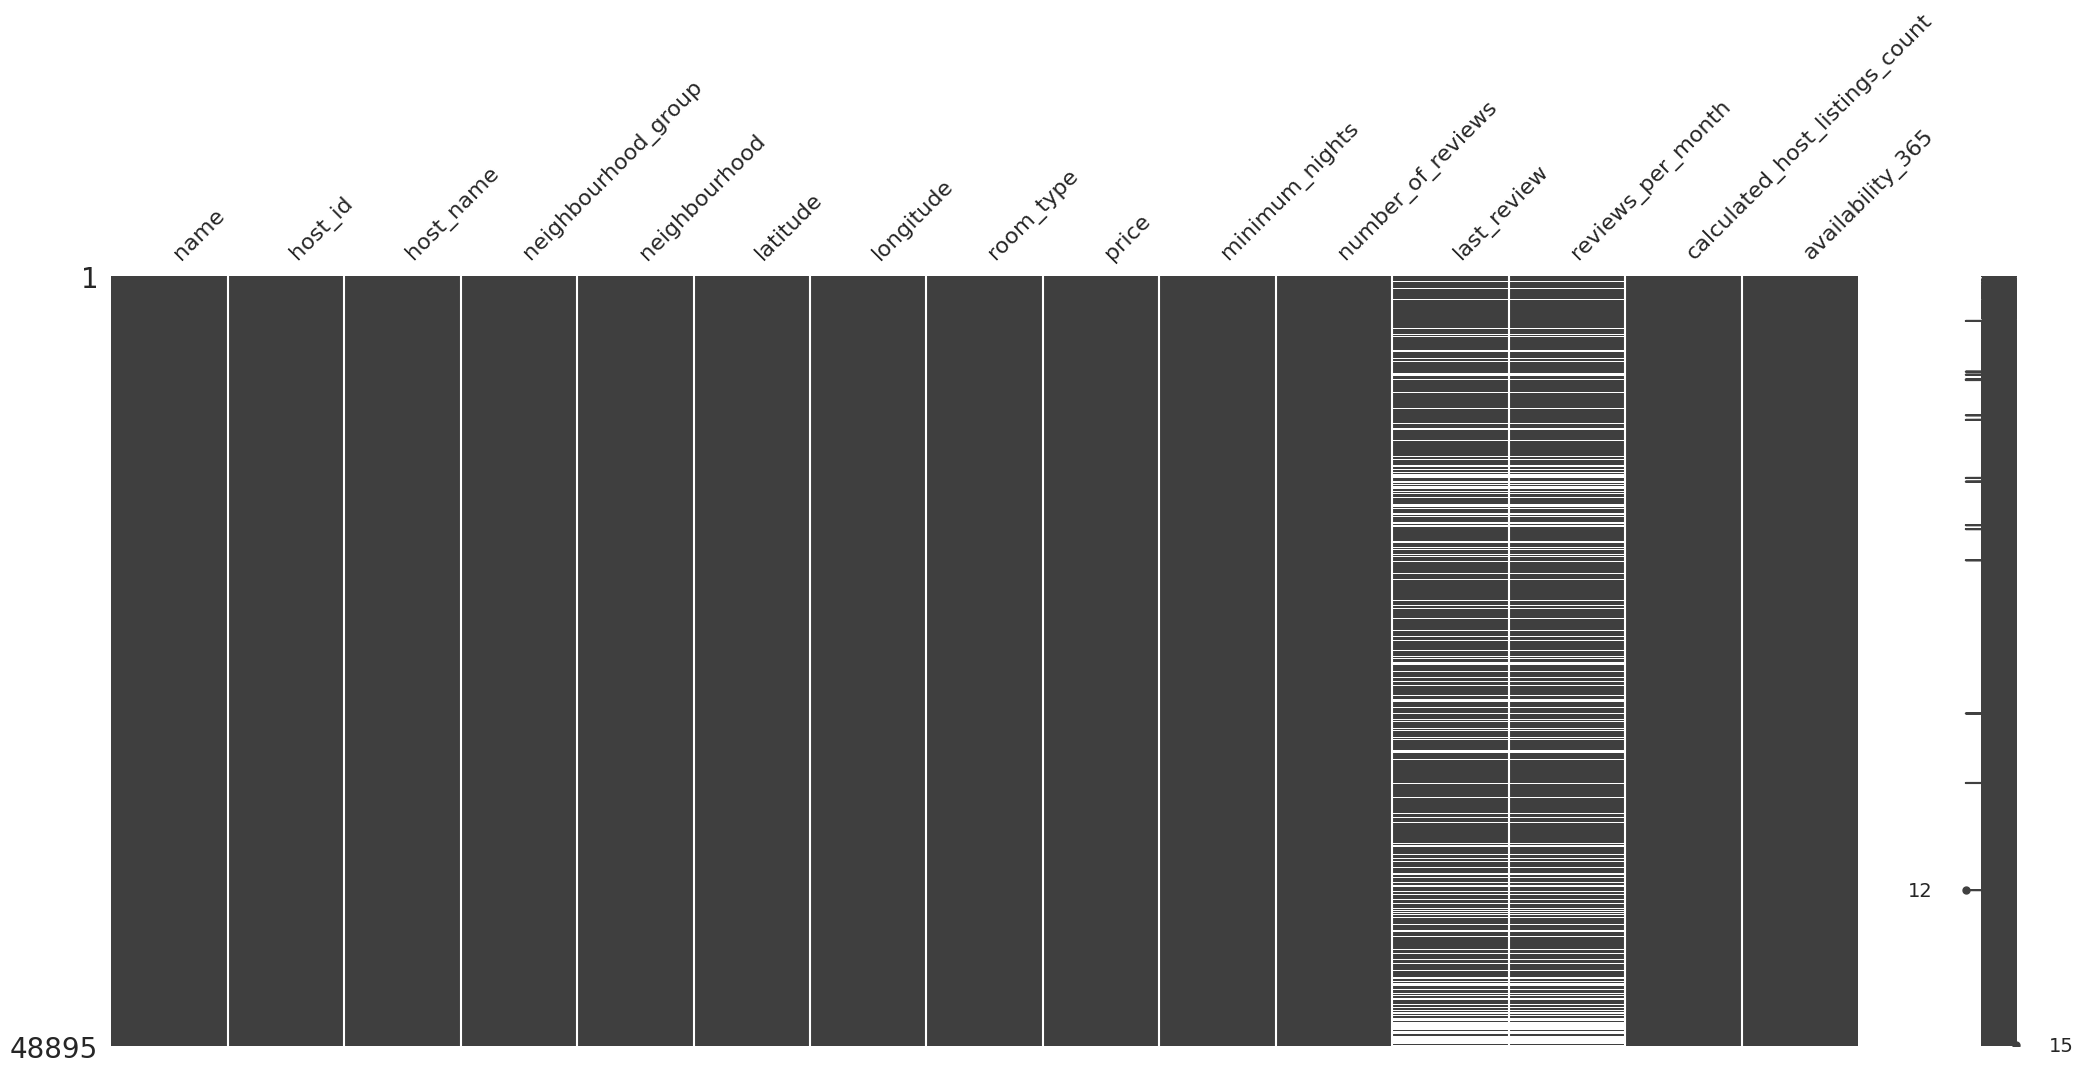

In [52]:
msno.matrix(df)


## 2. Tratamiento de valores faltantes

- Elimino columnas con un porcentaje de nulos demasiado alto.
- En las columnas con pocos nulos, aplico estrategias sencillas como rellenar con la media o 0 (según el caso).


In [53]:
## Eliminar columnas con muchos nulos (>40%)
threshold = 0.4
cols_high_na = missing_perc[missing_perc > threshold].index.tolist()

df = df.drop(columns=cols_high_na)
print("Columnas eliminadas por muchos nulos:", cols_high_na)
df.shape


Columnas eliminadas por muchos nulos: []


(48895, 15)

In [54]:
# Ejemplo: reviews_per_month tiene muchos 0 y algunos nulos
if "reviews_per_month" in df.columns:
    df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

df.isna().sum()


name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

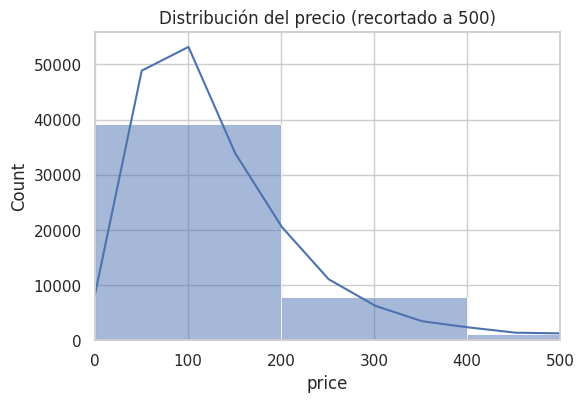

In [55]:
plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=50, kde=True)
plt.xlim(0, 500)
plt.title("Distribución del precio (recortado a 500)")
plt.show()


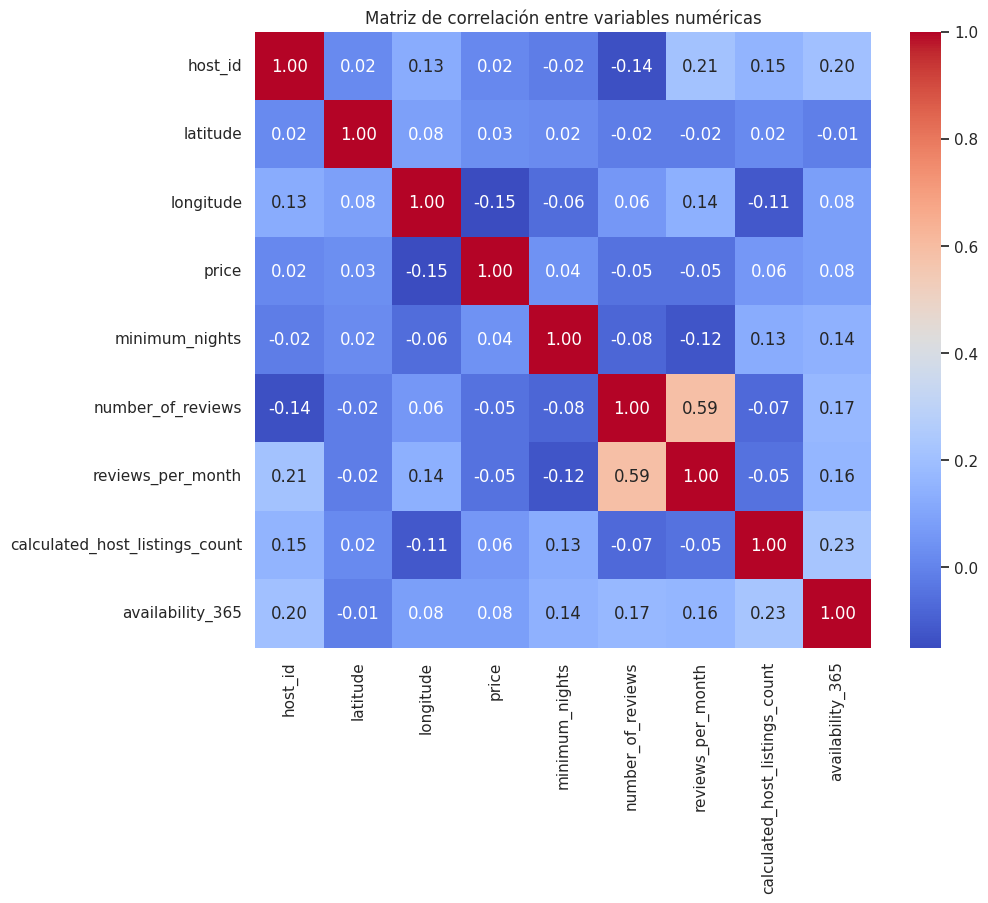

In [56]:

# Selecciono solo columnas numéricas
num_cols_corr = df.select_dtypes(include=[np.number]).columns

corr = df[num_cols_corr].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()



## 3. Correlaciones y outliers

- La matriz de correlación me ayuda a ver qué variables se relacionan más con el precio.
- También observo si hay relaciones fuertes entre variables (posible multicolinealidad).
- Para el precio aplico un filtrado básico de outliers para evitar casos extremadamente raros.


In [57]:
## Filtrado sencillo de outliers en precio y estancias
# Filtro valores extremos poco realistas
df = df[df["price"] >= 10]
df = df[df["price"] <= 500]

df = df[df["minimum_nights"] <= 30]

df.shape


(47125, 15)

In [58]:
## One Hot Encoding de room_type
df = pd.get_dummies(df, columns=["room_type"], drop_first=True)
df.head()


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room
id,,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,149,1,9,2018-10-19,0.21,6,365,True,False
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,225,1,45,2019-05-21,0.38,2,355,False,False
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,150,3,0,NaN,0.00,1,365,True,False
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,89,1,270,2019-07-05,4.64,1,194,False,False
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,80,10,9,2018-11-19,0.10,1,0,False,False


He transformado la variable categórica `room_type` en variables dummies (0/1) usando One Hot Encoding.
De este modo, el modelo puede utilizar esta información sin trabajar directamente con texto.


## 4. Escalado de variables numéricas

Escalo algunas variables numéricas para que estén en una magnitud similar.  
Esto es especialmente útil para la regresión lineal.


In [59]:
## Código de escalado
scaler = StandardScaler()

cols_to_scale = ["price", "minimum_nights", "number_of_reviews"]

for col in cols_to_scale:
    if col in df.columns:
        df[[col]] = scaler.fit_transform(df[[col]])

df[cols_to_scale].head()


,price,minimum_nights,number_of_reviews
id,,,
2539,0.198758,-0.557993,-0.327515
2595,1.061926,-0.557993,0.472766
3647,0.210115,-0.313621,-0.527586
3831,-0.482691,-0.557993,5.474527
5022,-0.584908,0.541681,-0.327515


## 5. Análisis Exploratorio de Datos (EDA)

Realizo algunas visualizaciones para comprender mejor el comportamiento de las variables.


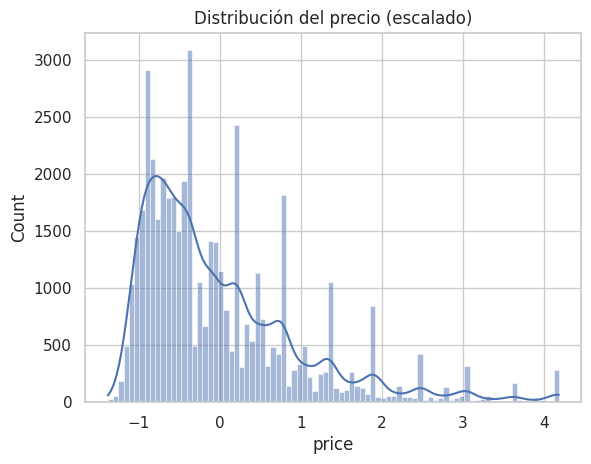

In [60]:
## Histograma de precio escalado
sns.histplot(df["price"], kde=True)
plt.title("Distribución del precio (escalado)")
plt.show()


Matriz de correlación para detectar relaciones entre variables numéricas tras las transformaciones.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw/AB_NYC_2019.csv")
df.set_index("id", inplace=True)

df.shape, df.head()



((48895, 15),
                                                   name  host_id    host_name  \
 id                                                                             
 2539                Clean & quiet apt home by the park     2787         John   
 2595                             Skylit Midtown Castle     2845     Jennifer   
 3647               THE VILLAGE OF HARLEM....NEW YORK !     4632    Elisabeth   
 3831                   Cozy Entire Floor of Brownstone     4869  LisaRoxanne   
 5022  Entire Apt: Spacious Studio/Loft by central park     7192        Laura   
 
      neighbourhood_group neighbourhood  latitude  longitude        room_type  \
 id                                                                             
 2539            Brooklyn    Kensington  40.64749  -73.97237     Private room   
 2595           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
 3647           Manhattan        Harlem  40.80902  -73.94190     Private room   
 3831       

Shape de df_num después de dropna: (38843, 9)


,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
host_id,1.000000,0.012946,0.141095,0.006269,-0.051693,-0.141819,0.296417,0.149412,0.155082
latitude,0.012946,1.000000,0.088152,0.031318,0.024808,-0.008746,-0.010142,0.004326,-0.022228
longitude,0.141095,0.088152,1.000000,-0.155361,-0.055418,0.054681,0.145948,-0.093325,0.102540
price,0.006269,0.031318,-0.155361,1.000000,0.025506,-0.035938,-0.030608,0.052903,0.078234
minimum_nights,-0.051693,0.024808,-0.055418,0.025506,1.000000,-0.069368,-0.121702,0.073479,0.101686
number_of_reviews,-0.141819,-0.008746,0.054681,-0.035938,-0.069368,1.000000,0.549868,-0.059784,0.193557
reviews_per_month,0.296417,-0.010142,0.145948,-0.030608,-0.121702,0.549868,1.000000,-0.009421,0.185791
calculated_host_listings_count,0.149412,0.004326,-0.093325,0.052903,0.073479,-0.059784,-0.009421,1.000000,0.182911
availability_365,0.155082,-0.022228,0.102540,0.078234,0.101686,0.193557,0.185791,0.182911,1.000000


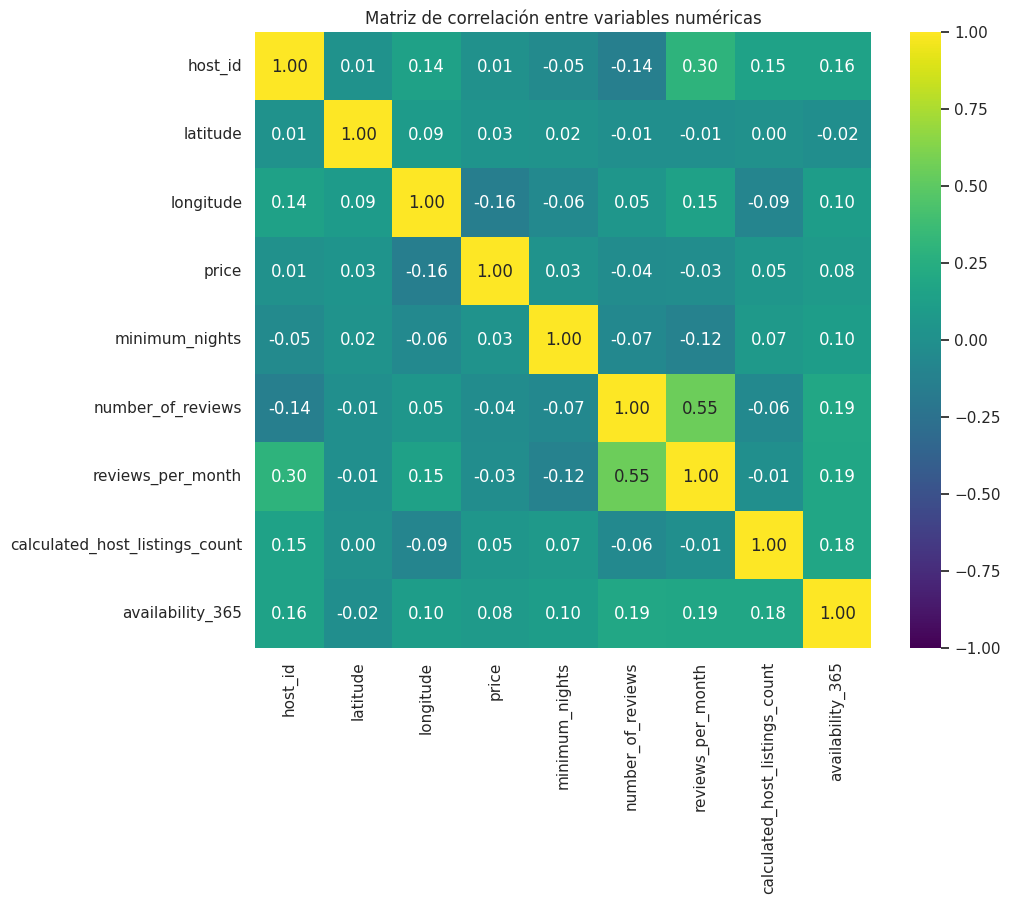

In [62]:
# Seleccionar solo columnas numéricas
df_num = df.select_dtypes(include=[np.number])

# Eliminar filas que tengan NaN en cualquier columna numérica
df_num = df_num.dropna()

print("Shape de df_num después de dropna:", df_num.shape)

# Calcular la matriz de correlación
corr = df_num.corr()

# Si quedara algún NaN en la matriz de correlación, lo relleno con 0
corr = corr.fillna(0)

display(corr)  # para ver la tabla de correlaciones

# Dibujar el heatmap con los valores
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,      # mostrar números
    fmt=".2f",       # formato de número
    cmap="viridis",
    vmin=-1, vmax=1,
    square=True
)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()








In [63]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


## 3. Correlaciones y outliers

- La matriz de correlación me ayuda a ver qué variables se relacionan más con el precio.
- También observo si hay relaciones fuertes entre variables (posible multicolinealidad).
- Para el precio aplico un filtrado básico de outliers para evitar casos extremadamente raros.


In [64]:
## Filtrado sencillo de outliers en precio y estancias
# Filtro valores extremos poco realistas
df = df[df["price"] >= 10]
df = df[df["price"] <= 500]

df = df[df["minimum_nights"] <= 30]

df.shape


(47125, 15)

In [65]:
# One Hot Encoding de room_type (solo si existe)
if "room_type" in df.columns:
    df = pd.get_dummies(df, columns=["room_type"], drop_first=True)

df.head()


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Private room,room_type_Shared room
id,,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,149,1,9,2018-10-19,0.21,6,365,True,False
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,225,1,45,2019-05-21,0.38,2,355,False,False
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,150,3,0,NaN,NaN,1,365,True,False
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,89,1,270,2019-07-05,4.64,1,194,False,False
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,80,10,9,2018-11-19,0.10,1,0,False,False


He transformado la variable categórica `room_type` en variables dummies (0/1) usando One Hot Encoding.
De este modo, el modelo puede utilizar esta información sin trabajar directamente con texto.


## 4. Escalado de variables numéricas

Escalo algunas variables numéricas para que estén en una magnitud similar.  
Esto es especialmente útil para la regresión lineal.


In [66]:
scaler = StandardScaler()

cols_to_scale = ["price", "minimum_nights", "number_of_reviews"]

for col in cols_to_scale:
    if col in df.columns:
        df[[col]] = scaler.fit_transform(df[[col]])

df[cols_to_scale].head()


,price,minimum_nights,number_of_reviews
id,,,
2539,0.198758,-0.557993,-0.327515
2595,1.061926,-0.557993,0.472766
3647,0.210115,-0.313621,-0.527586
3831,-0.482691,-0.557993,5.474527
5022,-0.584908,0.541681,-0.327515


## 5. Análisis Exploratorio de Datos (EDA)

Realizo algunas visualizaciones para comprender mejor el comportamiento de las variables.


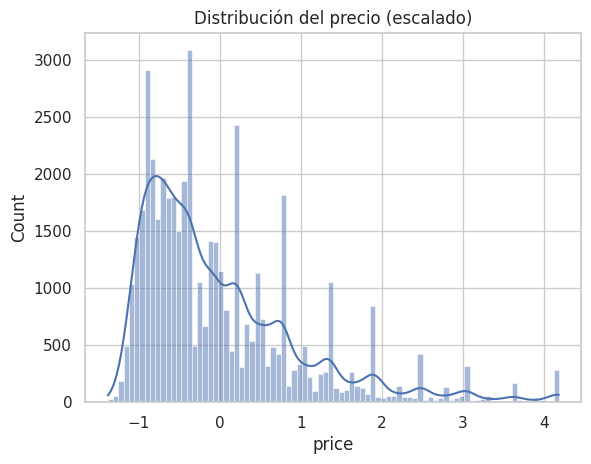

In [67]:
sns.histplot(df["price"], kde=True)
plt.title("Distribución del precio (escalado)")
plt.show()


Matriz de correlación para detectar relaciones entre variables numéricas tras las transformaciones.


In [68]:
df.shape


(47125, 16)

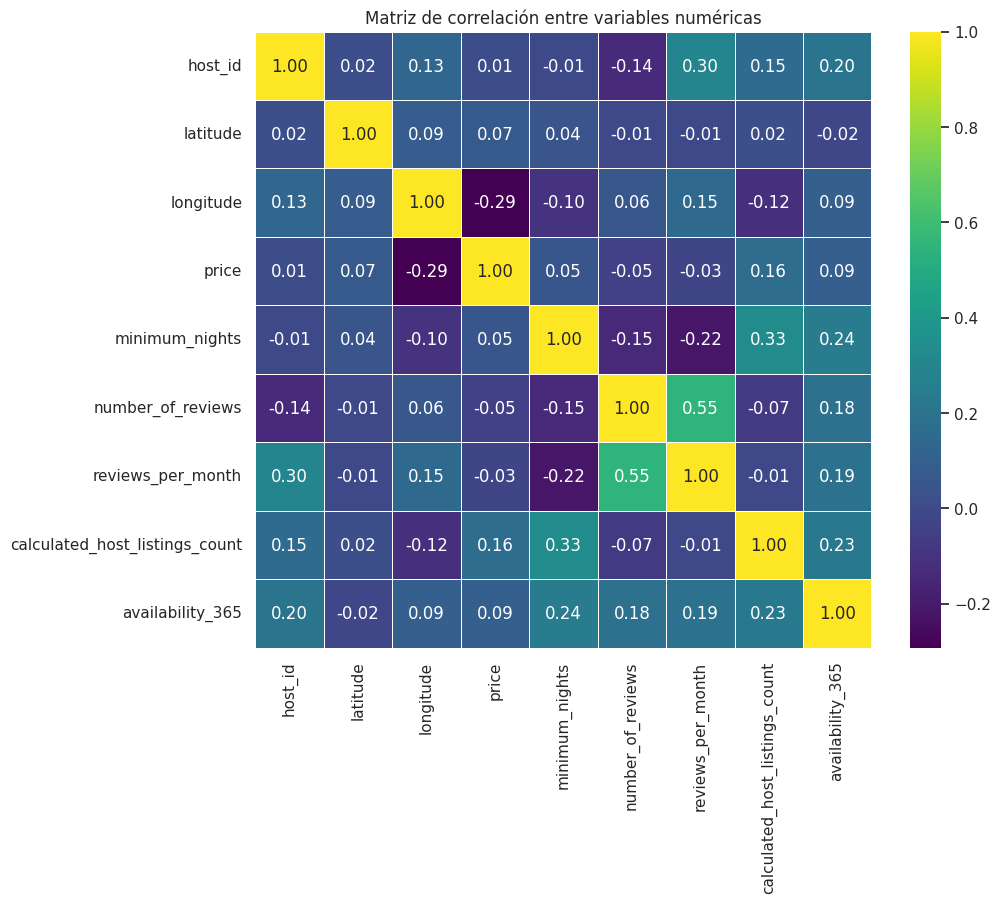

In [69]:

# Seleccionar solo columnas numéricas
df_num = df.select_dtypes(include=["int64", "float64", "float32"])

# Calcular la matriz de correlación
corr = df_num.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,      # Mostrar números
    fmt=".2f",       # Dos decimales
    cmap="viridis",  # Mapa de colores
    linewidths=0.5,  # Líneas entre celdas (visible)
    linecolor="white",
    square=True,     # Cuadraditos simétricos
    cbar=True        # Barra lateral
)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()


Análisis del precio según tipo de habitación.


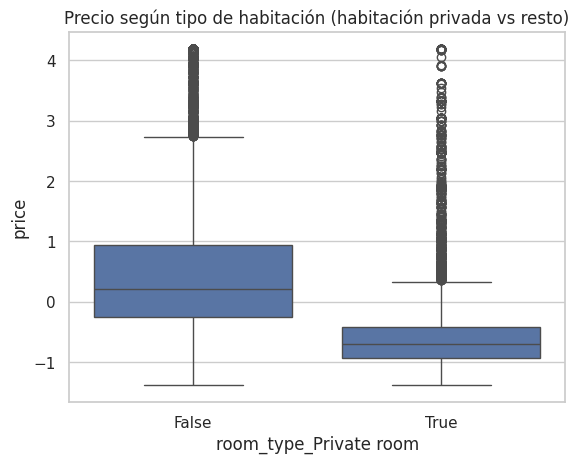

In [70]:
# Como he hecho dummies, puedo seguir usando la columna original si la guardé
# Si no, simplemente ignora esta parte o usa otra relación.
# Aquí asumo que aún tengo una columna 'room_type_Private room', etc.

sns.boxplot(x='room_type_Private room', y='price', data=df)
plt.title("Precio según tipo de habitación (habitación privada vs resto)")
plt.show()


## 6. Preparación final del dataset

Creo una versión final del dataset (`df_final`) solo con las columnas numéricas, lista para entrenar modelos de machine learning.


In [71]:
df_final = df.select_dtypes(include=["int64", "float64"])
df_final.head()


,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,
2539,2787,40.64749,-73.97237,0.198758,-0.557993,-0.327515,0.21,6,365
2595,2845,40.75362,-73.98377,1.061926,-0.557993,0.472766,0.38,2,355
3647,4632,40.80902,-73.94190,0.210115,-0.313621,-0.527586,NaN,1,365
3831,4869,40.68514,-73.95976,-0.482691,-0.557993,5.474527,4.64,1,194
5022,7192,40.79851,-73.94399,-0.584908,0.541681,-0.327515,0.10,1,0


### 6.1 División en train y test

Divido el dataset en conjunto de entrenamiento y prueba.


In [72]:
X = df_final.drop("price", axis=1)
y = df_final["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((37700, 8), (9425, 8))

## 7. Regresión lineal

Entreno un modelo de **regresión lineal** para predecir el precio de los alojamientos.


In [73]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Imputador: reemplaza NaN por la mediana de cada columna
imputer = SimpleImputer(strategy="median")

# Ajusto solo con X_train y transformo X_train y X_test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Vuelvo a ponerlo como DataFrame con los mismos nombres de columnas e índices
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

# Comprobar que ya no hay NaN
X_train.isna().sum().sum(), X_test.isna().sum().sum()


(np.int64(0), np.int64(0))

In [74]:
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

y_pred_lr = modelo_lr.predict(X_test)




### 7.1 Métricas del modelo de regresión lineal

Utilizo estas métricas:

- **MAE** (Mean Absolute Error): error medio en unidades de precio.
- **RMSE** (Root Mean Squared Error): penaliza más los errores grandes.
- **R²**: porcentaje de variabilidad del precio explicada por el modelo.


In [75]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R²:", r2_lr)


MAE: 0.7057554461997353
RMSE: 0.9535559482775026
R²: 0.11186432468725249


## 8. Visualización: precio real vs precio predicho

Represento el precio real frente al precio predicho por el modelo de regresión lineal.
Si el modelo fuera perfecto, todos los puntos estarían sobre la diagonal.


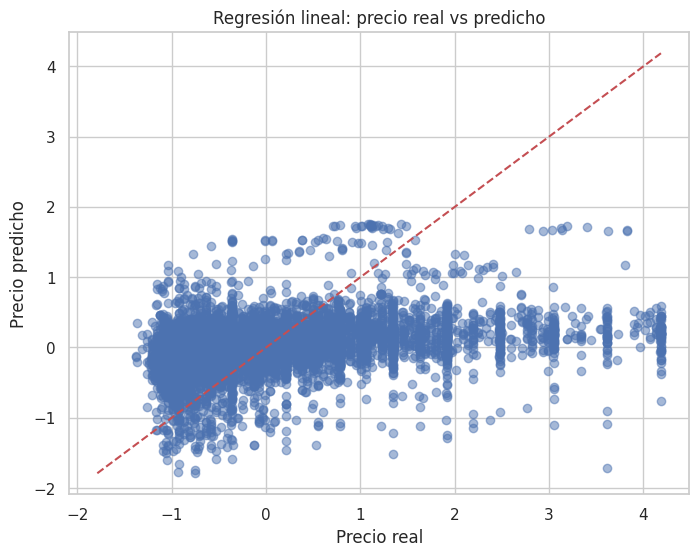

In [76]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Regresión lineal: precio real vs predicho")

min_val = min(y_test.min(), y_pred_lr.min())
max_val = max(y_test.max(), y_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.show()


## 9. Selección de características

Para analizar qué variables son más importantes en la predicción del precio, entreno un modelo de **Random Forest Regressor** sobre las mismas variables numéricas y utilizo su **feature importance**.


In [77]:
rf_fs = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_fs.fit(X_train, y_train)

importances = rf_fs.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

print("Top 15 características más importantes:\n")
for i in range(min(15, len(feature_names))):
    idx = indices[i]
    print(f"{i+1}. {feature_names[idx]}  -> importancia = {importances[idx]:.4f}")


Top 15 características más importantes:

1. longitude  -> importancia = 0.2943
2. latitude  -> importancia = 0.2112
3. host_id  -> importancia = 0.1441
4. availability_365  -> importancia = 0.0987
5. reviews_per_month  -> importancia = 0.0789
6. number_of_reviews  -> importancia = 0.0693
7. minimum_nights  -> importancia = 0.0557
8. calculated_host_listings_count  -> importancia = 0.0479


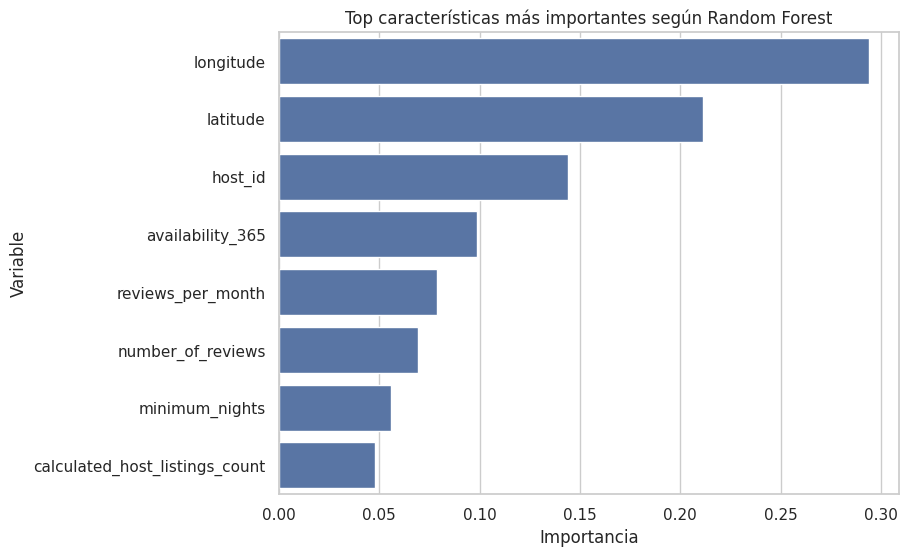

In [78]:
## Gráfico de barras de importancia
top_n = min(15, len(feature_names))
top_indices = indices[:top_n]

top_names = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(8,6))
sns.barplot(x=top_importances, y=top_names)
plt.title("Top características más importantes según Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()


## 10. Conclusiones

- He realizado una limpieza inicial del dataset (columnas constantes, nulos y outliers básicos de precio).
- He transformado variables categóricas (`room_type`) en dummies para poder usarlas en el modelo.
- He aplicado escalado a algunas variables numéricas para que la regresión lineal funcione mejor.
- He entrenado un modelo de **regresión lineal** para predecir el precio de los alojamientos y lo he evaluado con MAE, RMSE y R².
- He utilizado un **Random Forest Regressor** para analizar la importancia de las características y ver qué variables influyen más en el precio.

En una versión futura podría:
- Probar otros modelos (como Random Forest, Gradient Boosting o XGBoost) como modelos principales.
- Ajustar hiperparámetros.
- Añadir más variables derivadas (por ejemplo, agrupar barrios o crear rangos de precio).
